# NYC High School Data Analysis

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from mpl_toolkits.basemap import Basemap

# reading the New York city Schools data set
data_files =['ap_2010.csv', 'class_size.csv', 'demographics.csv', 'graduation.csv', 'hs_directory.csv', 'sat_results.csv']
data={}
for f in data_files:
    d = pd.read_csv('NYC School Data/{0}'. format(f))
    data[f.replace('.csv', '')] = d
all_survey = pd.read_csv('NYC School Data/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('NYC School Data/survey_d75.txt', delimiter='\t', encoding='windows-1252')
#concatinating all_survey and d75_survey
survey = pd.concat([all_survey, d75_survey], axis=0)

Reading the Data Dictionary available on the website to determine which columns will be useful for analysis.

In [2]:
Data_Dict = pd.ExcelFile('Data_Dictionary.xls')
Data_Dictionary = Data_Dict.parse('Sheet1')
Data_Dictionary

,2011 NYC School Survey Data Dictionary,Unnamed: 1
0,This data dictionary can be used with the scho...,NaN
1,NaN,NaN
2,Field Name,Field Description
3,dbn,School identification code (district borough n...
4,sch_type,"School type (Elementary, Middle, High, etc)"
5,location,School name
6,enrollment,Enrollment size
7,borough,Borough
8,principal,Principal name
9,studentsurvey,Only students in grades 6-12 partipate in the ...


Based on the above dictionary the columns listed below will be most relelvant.<br>
["dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

In [3]:
#copying dbn column to new column DBN for convenoence of processiing
survey['DBN']=survey['dbn']
#filtering survey so that it only contains the relelvant column
survey_fields=["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", 
               "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", 
               "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", 
               "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
survey = survey.loc[:, survey_fields]
data['survey'] = survey

while exploring some of the data sets, you can notice that some of them like 'class_size' and 'hs_directory' don't have DBN column. 'hs_directory' has a dbn column which we can just rename. However, 'class_size' doesn't have the column at all. 

In [4]:
data['class_size'].head(3)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN


But we can see that 'class_size' has columns like 'CSD' and 'School Code' which when combined can become 'DBN' column. The below code shows the conversion

In [5]:
#copying and combining
data['hs_directory']['DBN']=data['hs_directory']['dbn']
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0"+ string_representation
    
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN']= data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


In [6]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
data["class_size"].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


If we can create a column that totals up the SAT scores for the different sections of the of the exam, it'll make it easier to correlate scores. Hence we combine columns 'SAT Math Avg. Score', 'SAT Critical Reading Avg. Score' and 'SAT Writing Avg. Score' columns into one single column 'sat_score'

In [7]:
#first we convert the columns from str to numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data['sat_results'][c]=pd.to_numeric(data['sat_results'][c], errors='coerce')
    
#combining the columns    
data['sat_results']['sat_score'] = data['sat_results'][cols[0]]+data['sat_results'][cols[1]]+data['sat_results'][cols[2]]

in order to uncover any geographical paterns in the data we can parse the lattitude and longitude coordinates for each school. This will enable us to map the school.<br>
As the coordinates are in string format we use regular expressions to extract them.

In [8]:
def find_lat(loc):
    coords = re.findall('\(.+\)', loc)
    lat = coords[0].split(',')[0].replace('(', '')
    return lat

def find_lon(loc):
    coords = re.findall('\(.+\)', loc)
    lon = coords[0].split(',')[1].replace(')', '').strip()
    return lon

data['hs_directory']['lat']=data['hs_directory']['Location 1'].apply(find_lat)
data['hs_directory']['lon']=data['hs_directory']['Location 1'].apply(find_lon)

data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')

We need to combine out datasets inorder to compute correlations and perform some analysis. However, before that, we need to condense our data set. We need to do it because each value in the DBN column is unique, if we don't, we'll run into issues when time comes to combine the data sets.

Lets consider the class_size dataset. The first few rows of the dataset look as shown below

In [9]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


As we can see, the fiirst few rows all pertain to the same school, which is why the DBN appears more than once.<br>
As we are dealing with high schools, we only consider grades 9-12. <br>


In [10]:
data['class_size']['PROGRAM TYPE'].unique()

array(['GEN ED', 'CTT', 'SPEC ED', nan, 'G&T'], dtype=object)

As we can see from above unique values in PROGRAM TYPE, each school can have multiple program types. As GEN ED is the largest category by far, let's only consider rows where PROGRAM TYPE is GEN ED'

In [11]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


As we can see from above DBN still isn't unique. This is due to CORE COURSE(MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY) columns. <br>
The above columns seem to pertain to different classes. For Example the unique values of CORE SUBJECT (MS CORE and 9-12 ONLY) look as below

In [12]:
class_size['CORE SUBJECT (MS CORE and 9-12 ONLY)'].unique()

array(['ENGLISH', 'MATH', 'SCIENCE', 'SOCIAL STUDIES'], dtype=object)

These columns only seem to include certain subjects. We want our class size data to include every single class a school offers. We can achieve this by taking the average across all of the classes a school offers. This should give us unique DBN values while also incorporating as much data as poosible into the average.

In [13]:
class_size = class_size.groupby('DBN').agg(np.mean)
class_size.reset_index(inplace=True)
data['class_size'] = class_size

Since we've condensed class_size, lets condense demographics

In [14]:
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In this dataset the column that prevents a given DBN from being unique is Schoolyear. We only want rows where schoolyear is 20112012

In [15]:
data['demographics']= data['demographics'][data['demographics']['schoolyear'] == 20112012]
data['demographics'].head(5)

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


Finally we need to condense the graduation dataset

In [16]:
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


The Demographics and Cohort are what prevents DBN from being unique. Cohort refers to the year data represents and Demographics refers to a specific demographic group. As we want to pick data from the most recen cohort available, which will be 2006 and we want data from total cohort so we pick rows where Demographics = Total Cohort

In [17]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


Now we come to ap_2010 dataset. Here the AP test scores are in string format. So, we convert them into numeric values. 

In [18]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for i in cols:
    data['ap_2010'][i]= pd.to_numeric(data['ap_2010'][i], errors='coerce')

Now we combine all the datasets

In [19]:
combined = data['sat_results']
combined = combined.merge(data['ap_2010'], on='DBN', how='left')
combined = combined.merge(data['graduation'], on='DBN', how='left')
merge = ['class_size', 'demographics', 'survey', 'hs_directory']

for m in merge:
    combined = combined.merge(data[m], on='DBN', how='inner')

combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712...",3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...,40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",3.0,2.0,34.0,1005974.0,1.004390e+09,East Village ...,40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,NaN,"145 Stanton Street\nNew York, NY 10002\n(40.72...",3.0,1.0,3001.0,1004323.0,1.003540e+09,Chinatown ...,40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,...,NaN,"111 Columbia Street\nNew York, NY 10002\n(40.7...",3.0,2.0,2201.0,1004070.0,1.003350e+09,Lower East Side ...,40.718725,-73.979426


The merging resulted in some missing values, in this case we'll just fill in the missing data with overall mean. This will enable us to perform analysis which can't handle missing values. i.e. correlations

In [20]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...,40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",3.0,2.0,34.0,1005974.0,1.004390e+09,East Village ...,40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",3.0,1.0,3001.0,1004323.0,1.003540e+09,Chinatown ...,40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",3.0,2.0,2201.0,1004070.0,1.003350e+09,Lower East Side ...,40.718725,-73.979426


Now that we've a clean data, mapping the statistics out on a school district level can be an interesting way to analyze them. In order to do this, we create a new column that specifies the school district level.

In [21]:
def dist(digits):
    return digits[0:2]
combined['school_dist'] = combined['DBN'].apply(dist)

We apply correlation on the combined dataframe

In [22]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Based on the correlations above we plot a bar graph based on the survey_fields defined in the beginning, in order to further explore any surprising correlations.

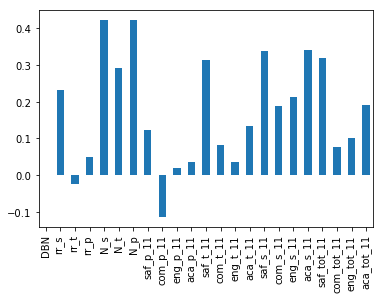

In [23]:
correlations[survey_fields].plot.bar()

1. There are high correlations between N_s, N_t, N_p and sat_score.<br>
2. It is more interesting to see that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. <br>
3. How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. <br>
4. The last interesting correlation is the aca_s_11 which correlates with sat_score. 

As above, we noticed how students perceived safety correlated with sat scores. Let's plot a scatter plot to further explore this relationship.

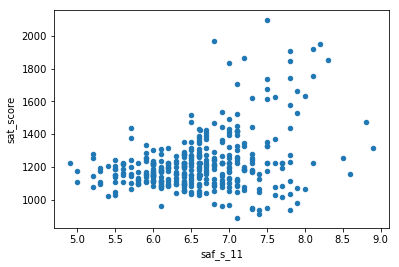

In [24]:
combined.plot.scatter("saf_s_11", "sat_score")

Though there is a correlation, it doesn't appear to be that strong. There are a few schools with high SAT scores and high safety scores. There are also a few schools with low safety scores and low SAT scores. Also, there is no school with safety score lower than 6.5 which has an average SAT score higher than 1400.

/Applications/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Applications/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Applications/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


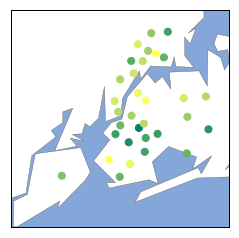

In [25]:
districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

From the map we can infer Upper Manhattan, certain parts of Queens and the Bronx have lower safety scores, whereas Brooklyn has high safety scores.

If we observe the given data, we can see that there are few columns that indicate the percentage of each race in a given school. Maybe, by plotting out the correlation between these columns and the correlation we can explore any relationship between them. 

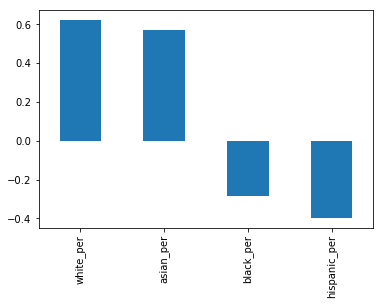

In [26]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

By reading the above graph we can say that higher percentage of white or asian students at a school correlates positively with sat score.

There are also columns that indicate percentage opf each gender at a school. This can be explored to see if there is any correlations between each percentage and sat scores.

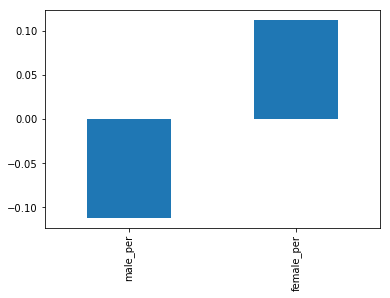

In [27]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

From the plot above, we can see that high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. However, neither correlation is extremely strong as they end between 0.11 & -0.11.

We can further explore this by plotting a scatter graph to evaluate the schools with high SAT scores and high female percentage.

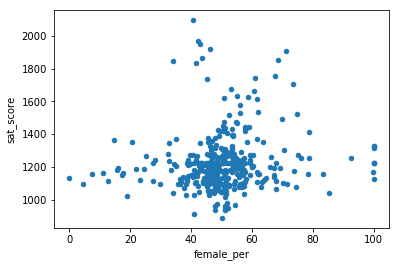

In [28]:
combined.plot.scatter("female_per", "sat_score")

Based on the scatter plot we can see that there is no strong correlation. This confirms our assumption in the previous steps.

Lets explore the correlation between male perc and low SAT scores.

In [ ]:
combined.plot.scatter("male_per", "sat_score")

Based on the above scatter plot we can see there in no string correlation here either. However, there is a cluster of schools with a high percentage of males (50 to 70), and high SAT scores.

In [ ]:
print(combined[(combined["male_per"] > 50) & (combined["sat_score"] > 1600)]["SCHOOL NAME"])

We may also think that there might be a high correlation between number of students who take AP exams and the school's SAT scores. Lets further explore this. 

In [ ]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter(x='ap_per', y='sat_score')

As it appears, there might be a relationship between the percentage of students who take the AP exam, and their average SAT scores. Though, it is not an extremely strong correlation.